<a href="https://colab.research.google.com/github/DeepLearning-Y4/TrafficSignRecognition/blob/main/TrafficSignRecognition_ResNet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TrafficSignRecognition_ResNet_model



In [3]:
# Mount Google Drive (optional if you stored the dataset there)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip "/content/drive/MyDrive/DL/Assignment/GTSRB.zip" -d "/content/drive/MyDrive/DL/Assignment/traffic-signs"


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/DL/Assignment/traffic-signs/GTSRB/Train/14/00014_00021_00023.png  
  inflating: /content/drive/MyDrive/DL/Assignment/traffic-signs/__MACOSX/GTSRB/Train/14/._00014_00021_00023.png  
  inflating: /content/drive/MyDrive/DL/Assignment/traffic-signs/GTSRB/Train/14/00014_00012_00025.png  
  inflating: /content/drive/MyDrive/DL/Assignment/traffic-signs/__MACOSX/GTSRB/Train/14/._00014_00012_00025.png  
  inflating: /content/drive/MyDrive/DL/Assignment/traffic-signs/GTSRB/Train/14/00014_00003_00002.png  
  inflating: /content/drive/MyDrive/DL/Assignment/traffic-signs/__MACOSX/GTSRB/Train/14/._00014_00003_00002.png  
  inflating: /content/drive/MyDrive/DL/Assignment/traffic-signs/GTSRB/Train/14/00014_00003_00016.png  
  inflating: /content/drive/MyDrive/DL/Assignment/traffic-signs/__MACOSX/GTSRB/Train/14/._00014_00003_00016.png  
  inflating: /content/drive/MyDrive/DL/Assignment/traffic-signs/GTSRB/Train/14/00

In [5]:
!pip install tensorflow keras matplotlib seaborn scikit-learn


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import os


In [7]:
train_dir = '/content/drive/MyDrive/DL/Assignment/traffic-signs/GTSRB/Train'
test_dir = '/content/drive/MyDrive/DL/Assignment/traffic-signs/GTSRB/Test'



Preprocess and Augment Data

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (64, 64)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 0 images belonging to 0 classes.


Build the ResNet50 Model

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 24,123,307 (92.02 MB)

 Trainable params: 535,595 (2.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Compile Model

Train Model

In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 221s 212ms/step - accuracy: 0.0543 - loss: 3.6535 - val_accuracy: 0.0765 - val_loss: 3.4306
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 192s 196ms/step - accuracy: 0.0863 - loss: 3.4437 - val_accuracy: 0.0996 - val_loss: 3.3640
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 195s 198ms/step - accuracy: 0.1098 - loss: 3.3555 - val_accuracy: 0.1147 - val_loss: 3.3063
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 188s 192ms/step - accuracy: 0.1257 - loss: 3.2982 - val_accuracy: 0.1310 - val_loss: 3.2622
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 188s 192ms/step - accuracy: 0.1404 - loss: 3.2361 - val_accuracy: 0.1418 - val_loss: 3.2124
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 186s 189ms/step - accuracy: 0.1538 - loss: 3.1946 - val_accuracy: 0.1488 - val_loss: 3.1752
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 186s 190ms/step - accuracy: 0.1628 - loss: 3.1439 - val_accuracy: 0.1481 - val_loss: 3.1417
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 183s 187ms/step - accuracy: 0.1716 -

In [31]:
train_loss, train_acc = model.evaluate(train_generator)
print(f"Training Accuracy: {train_acc*100:.2f}%")

981/981 ━━━━━━━━━━━━━━━━━━━━ 159s 163ms/step - accuracy: 0.4680 - loss: 1.8053
✅ Fine-Tuned Model Test Accuracy: 46.99%


Evaluate on Test Data

In [14]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your dataset
base_path = "/content/drive/MyDrive/DL/Assignment/traffic-signs/GTSRB"
test_dir = os.path.join(base_path, "Test")
test_csv_path = os.path.join(base_path, "Test.csv")

# Load the CSV
test_df = pd.read_csv(test_csv_path)
print("Test.csv columns:", test_df.columns)

# Adjust depending on your CSV column name
if 'Path' in test_df.columns:
    test_df['Path'] = test_df['Path'].apply(lambda x: os.path.join(test_dir, os.path.basename(x)))
elif 'Filename' in test_df.columns:
    test_df['Path'] = test_df['Filename'].apply(lambda x: os.path.join(test_dir, x))
else:
    test_df['Path'] = test_df.iloc[:, 0].apply(lambda x: os.path.join(test_dir, x))  # fallback

print(test_df.head())


Test.csv columns: Index(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId',
       'Path'],
      dtype='object')
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png


In [17]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
test_df['ClassId'] = test_df['ClassId'].astype(str)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Path',
    y_col='ClassId',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 12630 validated image filenames belonging to 43 classes.


In [18]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


395/395 ━━━━━━━━━━━━━━━━━━━━ 44s 111ms/step - accuracy: 0.2143 - loss: 2.9030
Test Accuracy: 21.23%


Classification Report & Confusion Matrix

395/395 ━━━━━━━━━━━━━━━━━━━━ 48s 113ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.21      0.32      0.25       720
           2       0.15      0.60      0.23       660
           3       0.21      0.44      0.28       420
           4       0.32      0.38      0.35       690
           5       0.52      0.84      0.64       720
           6       0.31      0.14      0.19       270
           7       0.18      0.04      0.06       210
           8       0.00      0.00      0.00       150
           9       0.60      0.65      0.62       360
          10       0.19      0.12      0.14       390
          11       0.00      0.00      0.00        60
          12       0.15      0.50      0.23       750
          13       0.00      0.00      0.00        90
          14       0.00      0.00      0.00        90
          15       0.00      0.00      0.00       120
          16       0.06      0.01      0.01       150
          17       0.00    

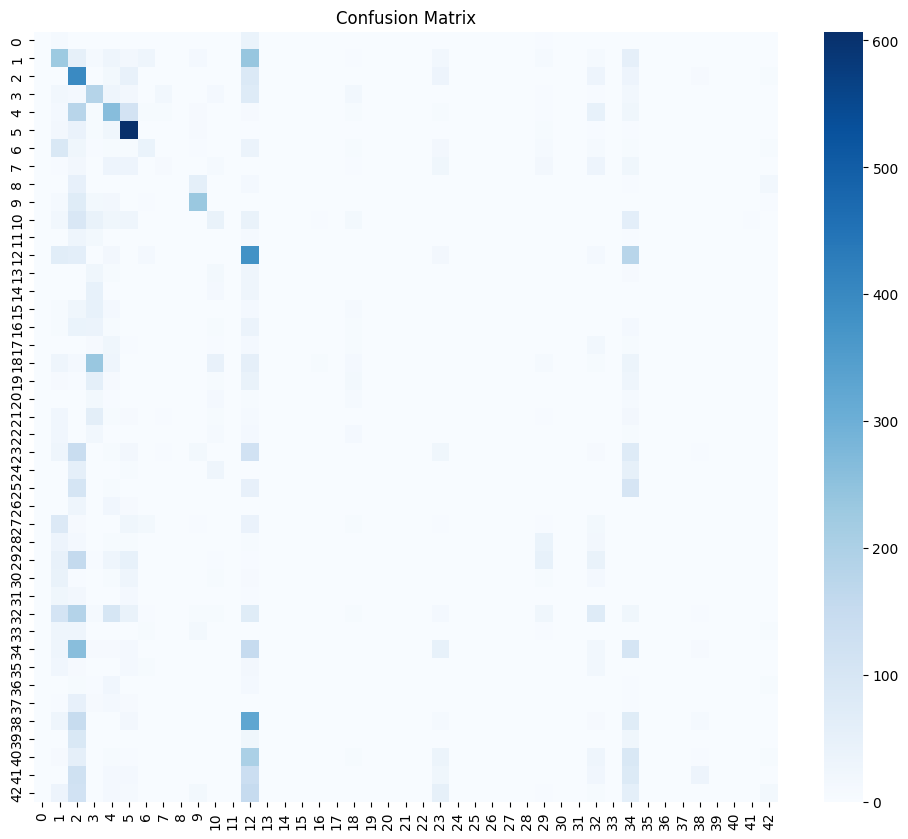

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_generator.classes, y_pred))

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap='Blues', annot=False)
plt.title('Confusion Matrix')
plt.show()


Save the Model

In [20]:
model.save('resnet_traffic_signs.h5')


Fine Tuning

In [21]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 219s 205ms/step - accuracy: 0.1506 - loss: 3.7776 - val_accuracy: 0.1935 - val_loss: 2.8365
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 194s 198ms/step - accuracy: 0.2602 - loss: 2.6134 - val_accuracy: 0.2426 - val_loss: 2.7193
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 188s 192ms/step - accuracy: 0.3193 - loss: 2.3748 - val_accuracy: 0.2817 - val_loss: 2.5601
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 197s 187ms/step - accuracy: 0.3630 - loss: 2.2028 - val_accuracy: 0.3219 - val_loss: 2.4739
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 183s 187ms/step - accuracy: 0.3990 - loss: 2.0508 - val_accuracy: 0.3506 - val_loss: 2.2569


In [22]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Fine-Tuned Model Test Accuracy: {test_acc*100:.2f}%")


395/395 ━━━━━━━━━━━━━━━━━━━━ 44s 110ms/step - accuracy: 0.4147 - loss: 1.9500
✅ Fine-Tuned Model Test Accuracy: 40.97%


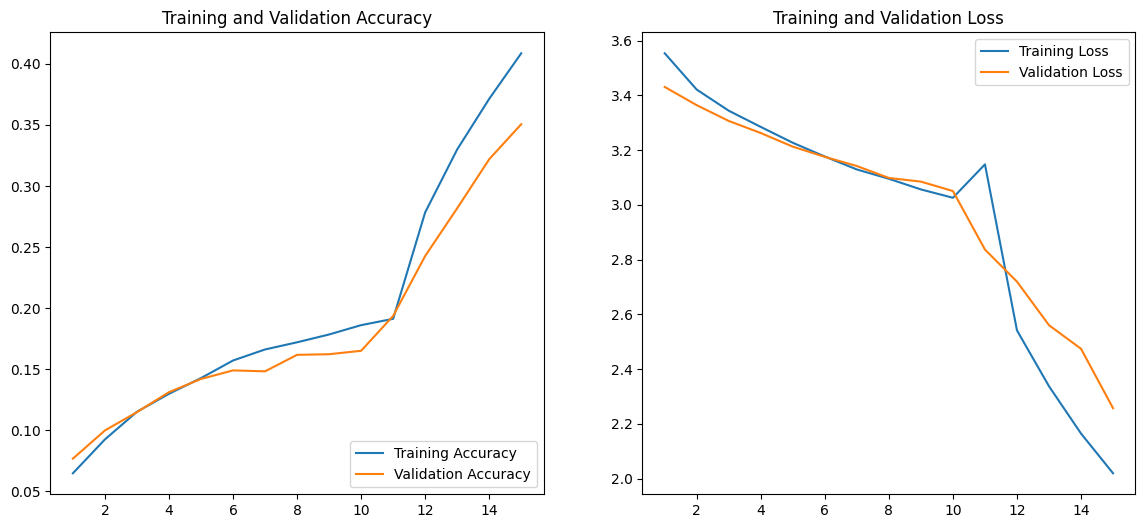

In [23]:
import matplotlib.pyplot as plt

# Combine both histories if you have 'history' and 'history_finetune'
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history.history['loss'] + history_finetune.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [24]:
#Generate a Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report:')
print(classification_report(test_generator.classes, y_pred))


395/395 ━━━━━━━━━━━━━━━━━━━━ 50s 118ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.38      0.40      0.39       720
           2       0.47      0.71      0.56       660
           3       0.43      0.55      0.49       420
           4       0.68      0.86      0.76       690
           5       0.92      0.92      0.92       720
           6       0.66      0.75      0.70       270
           7       0.65      0.54      0.59       210
           8       0.94      0.21      0.34       150
           9       0.73      0.82      0.77       360
          10       0.37      0.37      0.37       390
          11       0.00      0.00      0.00        60
          12       0.32      0.31      0.31       750
          13       0.00      0.00      0.00        90
          14       0.39      0.23      0.29        90
          15       0.14      0.09      0.11       120
          16  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


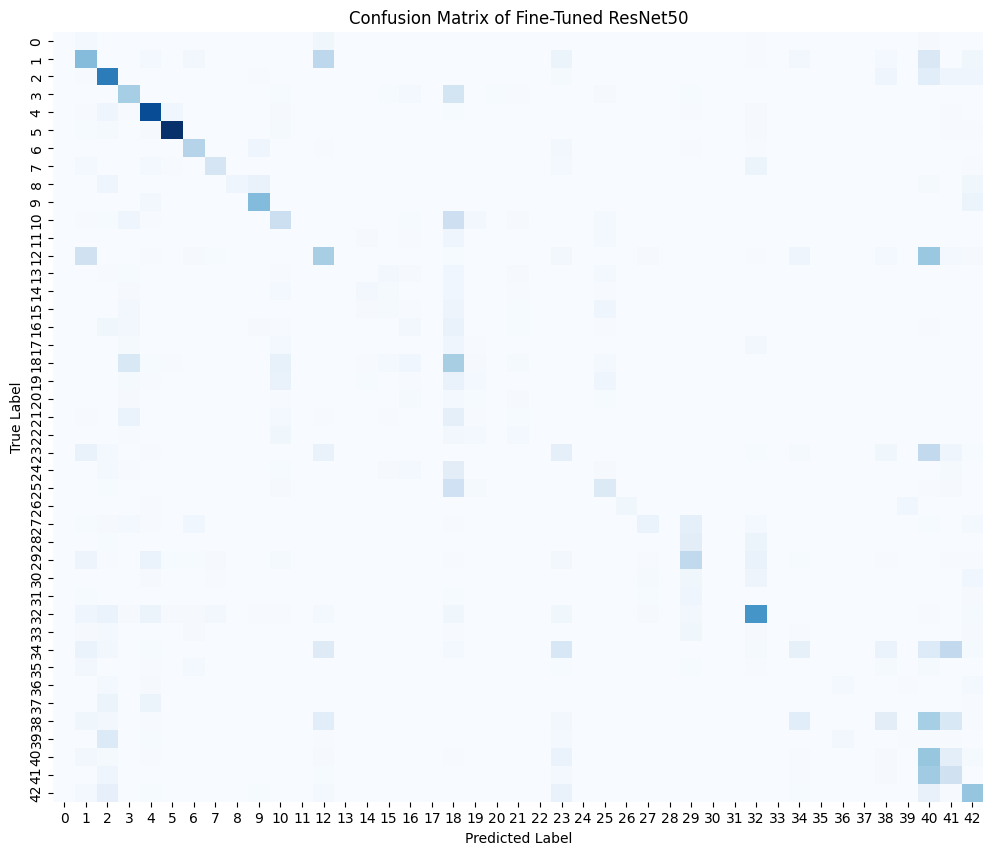

In [25]:
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap='Blues', cbar=False)
plt.title("Confusion Matrix of Fine-Tuned ResNet50")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Number of misclassified images: 7455


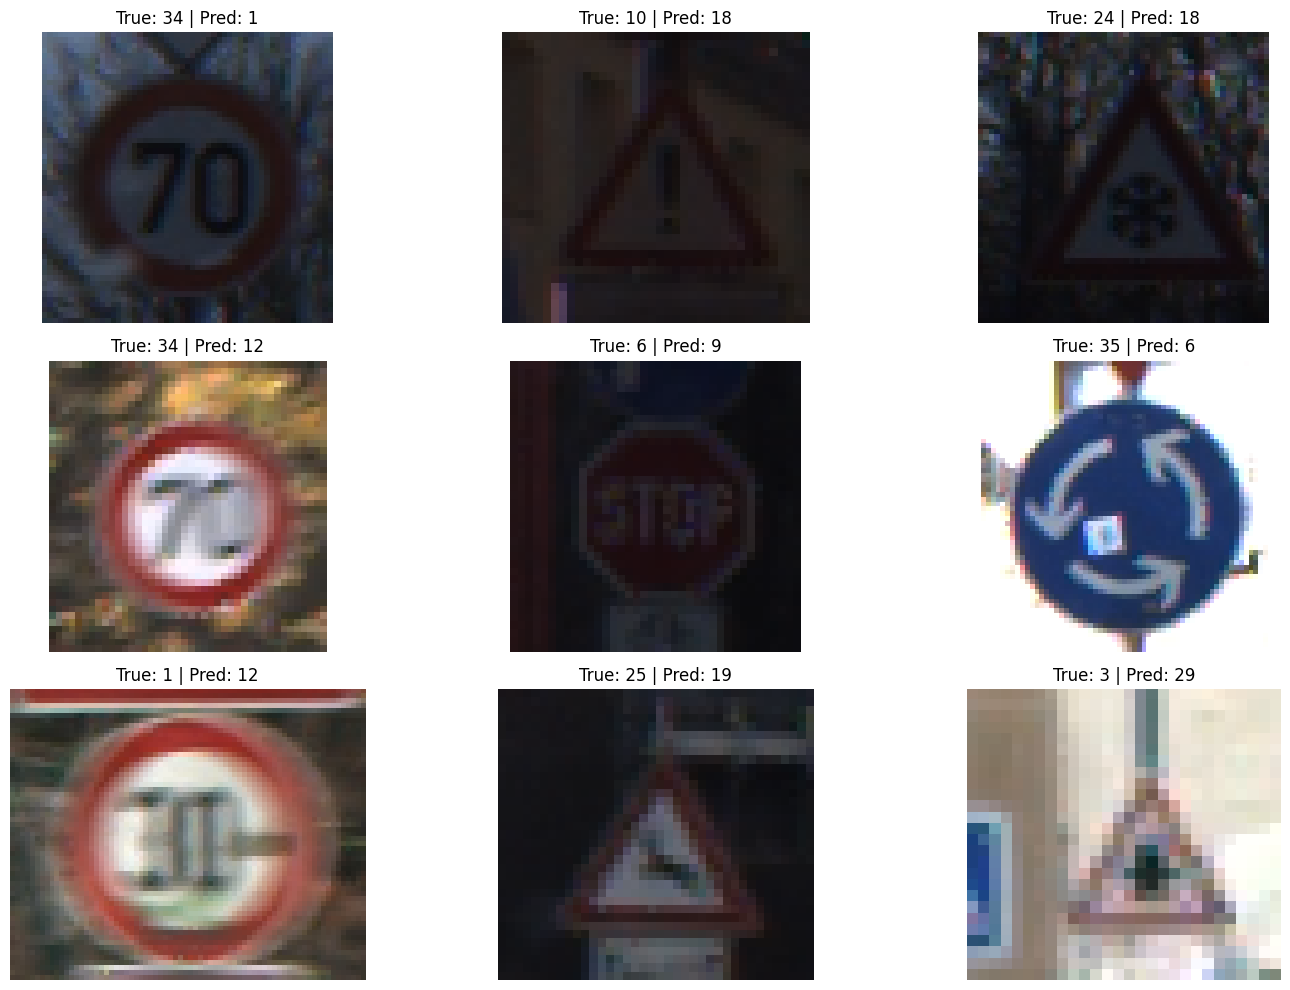

In [26]:
import random
import matplotlib.pyplot as plt

# Indices of wrong predictions
errors = np.where(y_pred != test_generator.classes)[0]
print(f"Number of misclassified images: {len(errors)}")

plt.figure(figsize=(15,10))
for i, idx in enumerate(random.sample(list(errors), 9)):
    img_path = test_generator.filepaths[idx]
    img = plt.imread(img_path)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f"True: {test_generator.classes[idx]} | Pred: {y_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [27]:
model.save("/content/fine_tuned_resnet50_traffic_signs.h5")
